## Trying to add the LMC contribution to the MW potential:

In [9]:
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.util import conversion
from streamtools.df import streamspraydf

from galpy.potential.mwpotentials import McMillan17
from stream_package.stream_package import graphics

In [5]:
ro = conversion.get_physical(McMillan17)['ro']
vo = conversion.get_physical(McMillan17)['vo']
to=conversion.time_in_Gyr(ro=ro,vo=vo)
mo=conversion.mass_in_msol(ro=ro,vo=vo)

gcname='Bootes III'
mass=1.82E7 * 5

# Orbit made from pace data
sixD_pace = [209.3, 26.8, 46.5, -1.176, -0.89, 197.5]
o = Orbit(vxvv = sixD_pace, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
o.turn_physical_off()

In [14]:
print(ro)
print(vo)

8.21
233.1


In [6]:
%%time

mass_lmc=1.0e11 #solar masses
rscale_lmc=10.2 #kpc

pot3 = McMillan17
tdisrupt=5

#Initialize and integrate the orbit of the LMC
#Note orbit has to be integrated back 5 Gyr
#Note we assume the LMC experienced dynamical friction due to MW
o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-tdisrupt/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot3[1], ro=ro,vo=vo)
o_lmc.integrate(ts,pot3+cdf)

#Setup a moving Hernquist potential to represent the LMC
pot3_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot3_lmc = MovingObjectPotential(o_lmc, pot3_lmc,ro=ro,vo=vo)

#Add the moving Hernquest potential to the MW
total_pot3 = [pot3]
total_pot3 += [moving_pot3_lmc]

CPU times: user 8.37 s, sys: 8.87 ms, total: 8.38 s
Wall time: 8.41 s


Pericentre is at 4.644830522842205 kpc
Apocentre is at 112.17424022377396 kpc


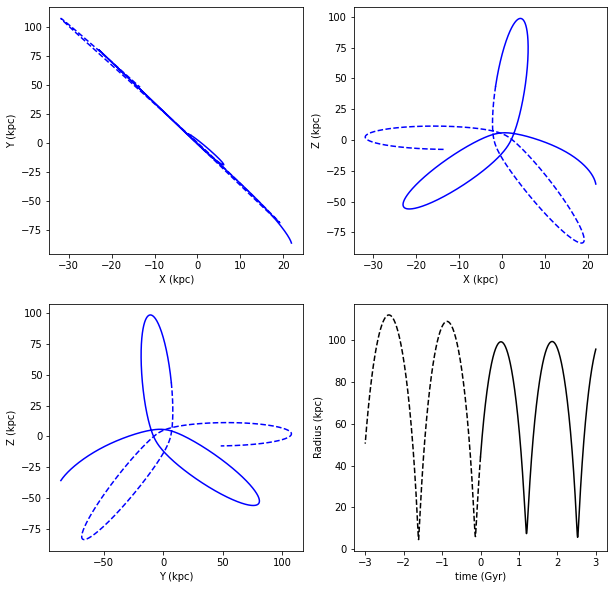

In [11]:
fig1 = graphics.orbit_plots(o, pot=pot3 + moving_pot3_lmc, tint=3)

In [7]:
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot3_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot3_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot3_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)

t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip3= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

Pericentre is at 6.332693554936009 kpc
Apocentre is at 97.43732214081516 kpc


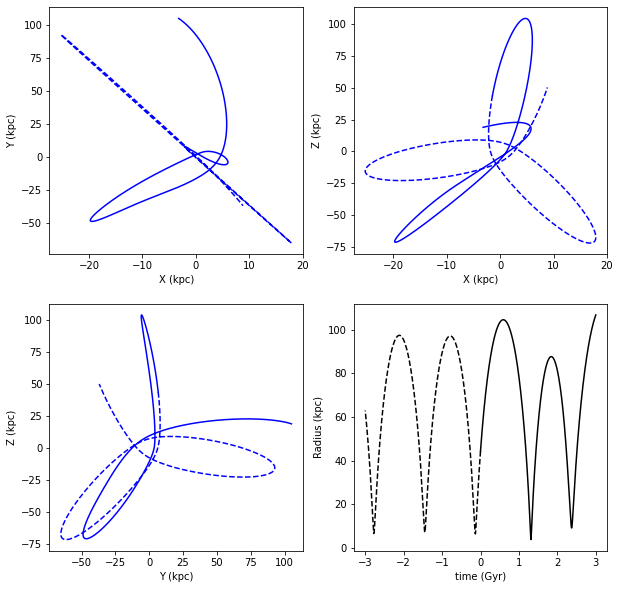

In [13]:
fig1 = graphics.orbit_plots(o, pot=pot3 + moving_pot3_lmc + nip3 , tint=3)